In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev

from pathlib import Path

##  Rainfall data

Here, we are using daily rainfall data from the CMH airport. Units are mm.

In [2]:
filein = "./data/cmh_daily_precip_mm.csv"
df = pd.read_csv(filein, parse_dates=["DATE"], index_col="DATE")

In [3]:
df

,STATION,NAME,PRCP
DATE,,,
1948-01-01,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",32.5
1948-01-02,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.8
1948-01-03,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
1948-01-04,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",2.5
1948-01-05,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
...,...,...,...
2022-12-27,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
2022-12-28,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
2022-12-29,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0


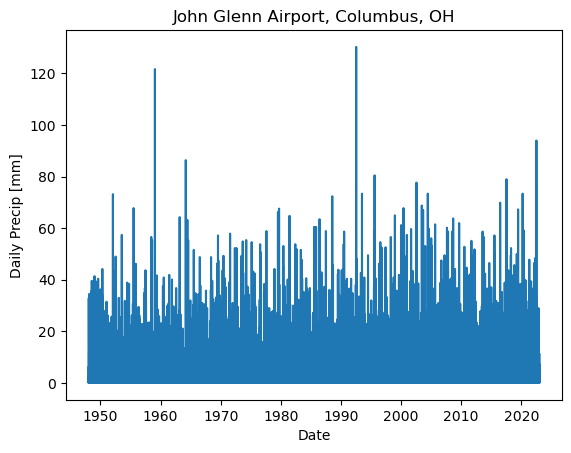

In [4]:
fig = plt.figure(1)
plt.plot(df.PRCP)  # The index column will be used for the x-axis if not otherwise specified
plt.xlabel('Date')
plt.ylabel('Daily Precip [mm]')
plt.title('John Glenn Airport, Columbus, OH')
plt.show()

fileout = 'cmh_daily_precip.png'
fig.savefig(fileout, dpi=300)

# IDF curve analysis 

Set 1: 2, 5, 10, 25 year return times. Use entire time series 

In [5]:
# Check for missing data
df.PRCP.isnull().sum()

0

In [6]:
# Number of years in the dataset
len(pd.unique(df.index.year))

75

In [7]:
def calc_idf_annualmax(df, p_var='PRCP', duration=24, years_to_calc=[1, 2, 5, 10, 25], output_dir=None):

    # Calculate annual max precip
    df2 = df[[p_var]].groupby(df.index.year).max()

    # Sort precip values from largest to smallest
    df2 = df2.sort_values(by=p_var, ascending=False)

    # Add a column for the rank of each year
    df2["m"] = np.arange(1, len(df2)+1)

    # Add a column for the return period
    df2["return_period"] = (len(df2)+ 1) / df2.m

    df3 = df2.copy()
    df3 = df2[['return_period', 'PRCP']]
    df3 = df3.set_index('return_period')

    for year in years_to_calc:
        if year not in df3.index:
            df3.loc[year] = np.nan
    df3 = df3.sort_index().interpolate(method='index', limit_direction='both')

    # rename precip column
    df3 = df3.rename(columns={p_var: 'precip_depth'})
    df3['precip_intensity'] = df3.precip_depth / duration

    df4 = df3[df3.index.isin(years_to_calc)]

    if output_dir is not None:
        df4.to_csv(Path(output_dir) / 'cmh_idf_summary.csv')
        df3.to_csv(Path(output_dir) / 'cmh_idf_full.csv')

    return df4

In [8]:
output_dir = './results/fullset/'
fullset_idf = calc_idf_annualmax(df, output_dir=output_dir)
fullset_idf

,precip_depth,precip_intensity
return_period,,
1.0,29.500000,1.229167
2.0,55.400000,2.308333
5.0,67.800000,2.825000
10.0,74.984211,3.124342
25.0,93.600000,3.900000


In [9]:
df_noaa = df[(df.index.year >= 1949) & (df.index.year <= 2000)]
df_noaa

,STATION,NAME,PRCP
DATE,,,
1949-01-01,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
1949-01-02,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
1949-01-03,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
1949-01-04,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",41.4
1949-01-05,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",8.4
...,...,...,...
2000-12-27,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.0
2000-12-28,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.3
2000-12-29,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",0.5


In [10]:
output_dir = './results/noaa/'
noaa_idf = calc_idf_annualmax(df, output_dir=output_dir)
noaa_idf


# NOAA uses a multiplier of 1.134 to adjust daily precipitation to 24-hour precip (since the 24 hour window might not fall in the same day)
noaa_idf['precip_depth_adjusted'] = noaa_idf.precip_depth * 1.134
noaa_idf['precip_intensity_adjusted'] = noaa_idf.precip_intensity * 1.134
noaa_idf


,precip_depth,precip_intensity,precip_depth_adjusted,precip_intensity_adjusted
return_period,,,,
1.0,29.500000,1.229167,33.453000,1.393875
2.0,55.400000,2.308333,62.823600,2.617650
5.0,67.800000,2.825000,76.885200,3.203550
10.0,74.984211,3.124342,85.032095,3.543004
25.0,93.600000,3.900000,106.142400,4.422600


In [11]:
def calc_idf_partialreturn(df, p_var='PRCP', duration=24, years_to_calc=[1, 2, 5, 10, 25], output_dir=None):

    df2 = df.copy()

    # Sort precip values from largest to smallest
    df2 = df2.sort_values(by=p_var, ascending=False)

    # Find n largest precip values
    n = len(pd.unique(df.index.year))
    df2 = df2.iloc[:n]
    print(f'Years: {n}')

    # Add a column for the rank of each year
    df2["m"] = np.arange(1, len(df2)+1)

    # Add a column for the return period
    df2["return_period_partial"] = (len(df2)+ 1) / df2.m
    df2["return_period_annual"] = 1 / (-np.exp(-1/df2.return_period_partial) + 1)

    df3 = df2.copy()
    df3 = df2[['return_period_annual', 'return_period_partial', 'PRCP']]
    df3 = df3.set_index('return_period_annual')

    for year in years_to_calc:
        if year not in df3.index:
            df3.loc[year] = np.nan
            df3.loc[year, 'return_period_partial'] = -1 / (np.log(1-(1/year)))
    df3[p_var] = df3.sort_index().interpolate(method='index', limit_direction='both')[p_var]

    # rename precip column
    df3 = df3.rename(columns={p_var: 'precip_depth'})
    df3['precip_intensity'] = df3.precip_depth / duration

    df4 = df3[df3.index.isin(years_to_calc)]

    if output_dir is not None:
        df4.to_csv(Path(output_dir) / 'cmh_idf_summary.csv')
        df3.to_csv(Path(output_dir) / 'cmh_idf_full.csv')

    return df4

In [12]:
output_dir = './results/oldest10/'
df_oldest10 = df[(df.index.year >= 1948) & (df.index.year <= 1957)]
oldest10 = calc_idf_partialreturn(df_oldest10, output_dir=output_dir)
oldest10


Years: 10


/var/folders/nz/qzmpqd690vx_df6hvrfqjdsr0000gn/T/ipykernel_21705/3232294149.py:27: RuntimeWarning: divide by zero encountered in log
  df3.loc[year, 'return_period_partial'] = -1 / (np.log(1-(1/year)))


,return_period_partial,precip_depth,precip_intensity
return_period_annual,,,
1.0,0.000000,40.400000,1.683333
2.0,1.442695,43.371727,1.807155
5.0,4.481420,62.017538,2.584064
10.0,9.491222,71.717796,2.988242
25.0,24.496598,73.200000,3.050000


In [13]:
output_dir = './results/recent10/'
df_recent10 = df[(df.index.year >= 2013) & (df.index.year <= 2022)]
recent10 = calc_idf_partialreturn(df_recent10, output_dir=output_dir)
recent10


Years: 10


/var/folders/nz/qzmpqd690vx_df6hvrfqjdsr0000gn/T/ipykernel_21705/3232294149.py:27: RuntimeWarning: divide by zero encountered in log
  df3.loc[year, 'return_period_partial'] = -1 / (np.log(1-(1/year)))


,return_period_partial,precip_depth,precip_intensity
return_period_annual,,,
1.0,0.000000,52.300000,2.179167
2.0,1.442695,57.715180,2.404799
5.0,4.481420,75.886366,3.161932
10.0,9.491222,89.882767,3.745115
25.0,24.496598,94.000000,3.916667


# Probable maximum precipitation

Probable maximum precipitation (PMP): The theoretical maximum depth of precipitation that can occur over a specified area at a certain time of year.


The probable maximum precipitation for a specific duration (m) is given as:

$$ P_m = \overline{P} + k_m\sigma_p $$

$k_m$ is described by the Hurst-Kolmogorov distribution for extreme values – Koutsoyiannis (1999):

$$F(k_m) = 1-1/T = \exp \left\{ - \left[ 1 + \frac{0.13(k_m - 0.44)}{0.60} \right]^{-7.69} \right\}$$

This equation was fitted using a particular dataset, and may not perform as well in other places. We could instead fit the extreme value distribution to observations in a location of interest.  



## Calculate the Annual Maximum Daily precipitation

This dataset already has a 1-day duration, so we don't need to do any aggregation to get to the correct duration.

If we needed to aggregate to a different duration, we could use the [resample function in pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

But in this case we just need to find the maximum value for each year:

In [14]:
annual_p_max = df.groupby(df.index.year)['PRCP'].max()

In [15]:
annual_p_max

DATE
1948    39.6
1949    41.4
1950    44.2
1951    31.5
1952    73.2
        ... 
2018    52.3
2019    67.3
2020    73.4
2021    47.8
2022    94.0
Name: PRCP, Length: 75, dtype: float64

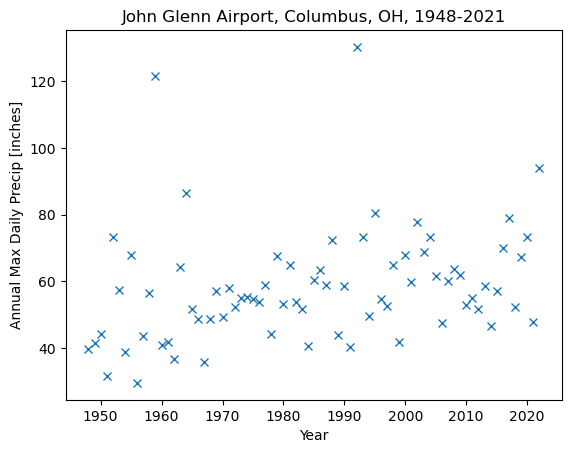

In [16]:
# Plot Annual Max Daily Precip
plt.figure(2)
plt.plot(annual_p_max, 'x')
plt.xlabel('Year')
plt.ylabel('Annual Max Daily Precip [inches]')
plt.title('John Glenn Airport, Columbus, OH, 1948-2021')
plt.show()

In [17]:
annual_p_max.describe()

count     75.000000
mean      58.201333
std       17.006235
min       29.500000
25%       48.300000
50%       55.400000
75%       64.900000
max      130.300000
Name: PRCP, dtype: float64

In [18]:
p_mean = annual_p_max.mean()
p_stdev = annual_p_max.std()

In [19]:
from scipy.optimize import fsolve

def koutsoyiannis(k, T=100):
    return np.exp(-(1 + (0.13 * (k - 0.44))/0.6) **(-7.69)) - (1 - 1/T)

km = fsolve(koutsoyiannis, [0], args=(100))[0]

In [20]:
km

4.219260899538897

In [21]:
pmp = p_mean + km * p_stdev
pmp

129.95507526441924

In [22]:
pmp_intensity  = pmp / 24
pmp_intensity

5.414794802684135

## Fitting the generalized extreme value distribution

Here, we will use the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme) module to fit the GEV distribution:

In [23]:
# Fitting extreme value distribution
AMRdt = annual_p_max.dropna()
Params = gev.fit(AMRdt)
T = np.arange(2, 101)
PT = gev.ppf((1 - 1/T), *Params)

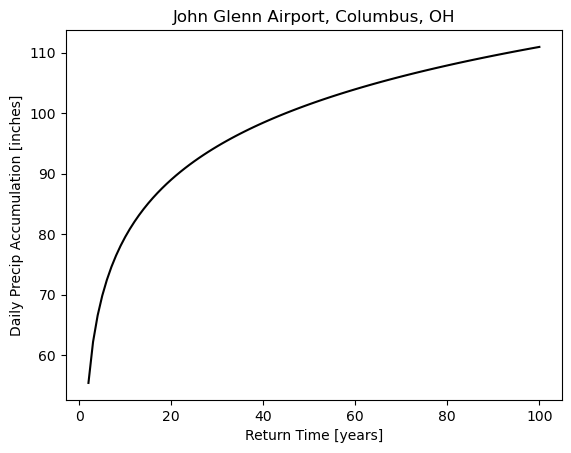

In [24]:
# Plotting the fitted distribution of precipitation
plt.figure(3)
plt.plot(T, PT, 'k')
plt.xlabel('Return Time [years]')
plt.ylabel('Daily Precip Accumulation [inches]')
plt.title('John Glenn Airport, Columbus, OH')
plt.show()

In [25]:
p_gev = gev.ppf((1 - 1/100), *Params)
p_gev

110.93081414026099

In [26]:
p_gev_intensity = p_gev / 24
p_gev_intensity

4.622117255844208

In [27]:
Params

(-0.019709235997929037, 50.831755820947414, 12.481283849710454)

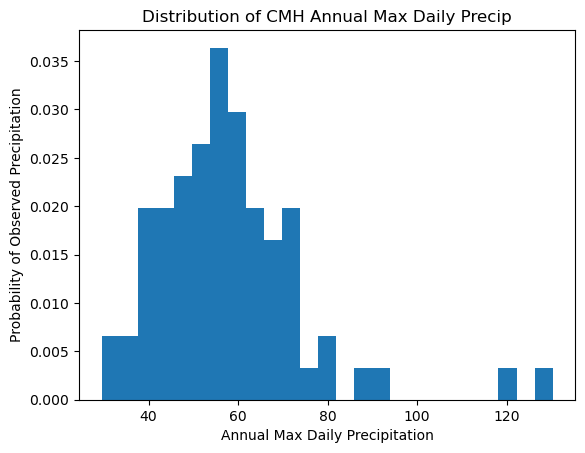

In [28]:
# Histogram (empirical distribution) of AMR
plt.figure(4)
plt.hist(AMRdt, bins=25, density=True)
plt.xlabel('Annual Max Daily Precipitation')
plt.ylabel('Probability of Observed Precipitation')
plt.title('Distribution of CMH Annual Max Daily Precip')
plt.show()